<a href="https://colab.research.google.com/github/MarianiPedro/topicos_especiais_CNN/blob/main/ap1_linear_classifier_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = True
FOLDERNAME = 'Colab Notebooks/CNN_2025_1/'   # only used if TEST_ON_COLAB is True

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

# Atividade de programação 1 (AP1)
## Classificação linear

Responda as questões indicadas e preencha os campos indicados com o tag `TODO`.

**1. (0,5 pontos)** Pesquise um dataset de classificação imagens de sua preferência (exceto mnist) utilizando o site `https://openml.org/`. O dataset será baixado através de função `fetch_openml` da biblioteca `scikit-learn`. Para essa atividade, o dataset deve ter a mesma estrutura de pixels/labels ($X$, $y$) vistos em exemplos de aula.

Dica: verifique datasets famosos em `https://medium.com/data-science-bootcamp/famous-machine-learning-datasets-you-need-to-know-dd031bf74dd`.

In [4]:
# TODO: Set the dataset ID #################
#DATASET_OPENML_ID = 41983  ## cifar100

#DATASET_OPENML_ID = 40996  #fashion mnist

DATASET_OPENML_ID = 41084
############################################

assert DATASET_OPENML_ID is not None, "DATASET_OPENML_ID is not set"

In [5]:
# Create dataset directory
import os

if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount("/content/drive")
    cache_dir = f"/content/drive/My Drive/{FOLDERNAME}/dataset/{DATASET_OPENML_ID}"
else:
    cache_dir = f"dataset/{DATASET_OPENML_ID}"

os.makedirs(cache_dir, exist_ok=True)

Mounted at /content/drive


In [6]:
# Fetching the dataset
from sklearn.datasets import fetch_openml
import numpy as np

X_file_path = f"{cache_dir}/X.npy"
y_file_path = f"{cache_dir}/y.npy"

# Check if the dataset files already exist
if not (os.path.exists(X_file_path) and os.path.exists(y_file_path)):
    # Fetch the dataset where X is the data and y is the target
    X, y = fetch_openml(data_id=DATASET_OPENML_ID, as_frame=False, cache=True, return_X_y=True)

    # Save the dataset as numpy arrays
    np.save(X_file_path, X.astype(np.float32))
    np.save(y_file_path, y)
    print(f"{DATASET_OPENML_ID} dataset downloaded and saved successfully to {cache_dir}.")
else:
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print(f"{DATASET_OPENML_ID} dataset already exists in {cache_dir}. Skipping download.")

print(X.shape)
print(X.min(), X.max())

41084 dataset already exists in /content/drive/My Drive/Colab Notebooks/CNN_2025_1//dataset/41084. Skipping download.
(575, 10304)
1.0 239.0


**2. (0,5 pontos)** Baseado no vetor de rótulos (target, $y$), calcule o número de classes presentes no conjunto de dados.

In [7]:
# TODO: Calculate the number of classes ####
num_classes = len(np.unique(y))
############################################

assert num_classes > 0, "num_classes is not set"
print(f"Number of classes: {num_classes}")

Number of classes: 20


Visualizando alguns amostras do dataset.

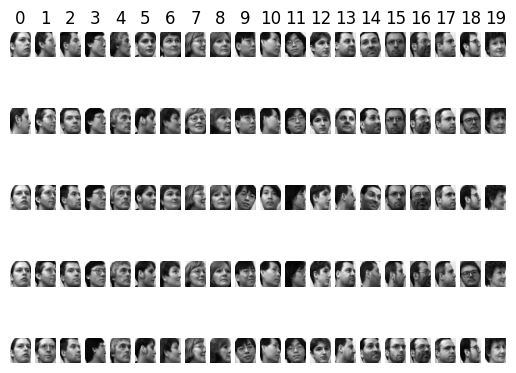

In [9]:
import matplotlib.pyplot as plt

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [int(class_id) for class_id in np.unique(y)]
samples_per_class = 5
for cls in classes:
    idxs = np.flatnonzero(y == str(cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].reshape((112,92)).astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**3. (2 pontos)** Agora, você precisa particionar o conjunto de dados em treino, validação e teste.

Use a função `train_test_split` do módulo `sklearn.model_selection` para dividir o conjunto de dados (`X` e `y`) em um conjunto de treinamento e um conjunto temporário, com 80% dos dados para treinamento e 20% para o conjunto temporário.

Em seguida, divida o conjunto temporário igualmente em conjuntos de validação e teste. Portanto, no final, você deve ter 80% dos dados para treinamento, 10% para validação e 10% para teste.


In [10]:
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
np.random.seed(42)

# Convert labels from string to integer
y = y.astype(int)

# TODO: Split the dataset into train, validation, and test sets #################
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
################################################################################

assert X_train is not None, "X_train is not set"
assert y_train is not None, "y_train is not set"
assert X_val is not None, "X_val is not set"
assert y_val is not None, "y_val is not set"
assert X_test is not None, "X_test is not set"
assert y_test is not None, "y_test is not set"

print(f"Train set size: {len(X_train)}")
print(f"Val set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 460
Val set size: 57
Test set size: 58


# Treinamento

Nesta parte da atividade, abordaremos o processo de treinamento. Para isso, serão defindas algumas funções auxiliares:

In [11]:
def cross_entropy_loss(W, X, y_true):
    """
    Compute the cross entropy.

    Args:
    W: np.array of size (D, C), where D is the number of features and C is the number of classes.
    X: np.array of size (N, D), where N is the number of data points.
    y_true: np.array of size (N), these are the true labels.

    Returns:
    float: the cross entropy loss.
    float: the gradient of the loss with respect to the weights W.
    """
    logits = X.dot(W)
    y_pred = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True) # softmax
    N = y_pred.shape[0]
    log_likelihood = -np.log(y_pred[range(N), y_true])
    loss = np.sum(log_likelihood) / N

    # Compute the gradient
    y_pred[range(N), y_true] -= 1
    grad = np.dot(X.T, y_pred) / N

    return loss, grad


def predict_class(X, W):
    """
    Compute the predicted class using the given input data and weights.

    Parameters:
    X (numpy.ndarray): Input data.
    W (numpy.ndarray): Weights.

    Returns:
    numpy.ndarray: Predicted classes.
    """
    scores = np.dot(X, W)
    return np.argmax(scores, axis=1)


def accuracy_score(y_true, y_pred):
    """
    Compute the accuracy score.

    Parameters:
    y_true (numpy.ndarray): True labels.
    y_pred (numpy.ndarray): Predicted labels.

    Returns:
    float: Accuracy score.
    """
    return np.mean(y_true == y_pred)

**4. (6 pontos)** Nessa questão, você deve completar os espaços indicados de modo a implementar o processo de treinamento. Utilize as funções recém definidas.

In [12]:
# TODO: Set learning rate #####################################
learning_rate = 1e-6
###############################################################

assert learning_rate is not None, "learning_rate is not set"

# Batch size
batch_size = 1000

# Number of epochs
num_epochs = 100

# Initialize weights
W = np.random.randn(X_train.shape[1], num_classes) * 0.0001

# Initialize best accuracy and best weights
best_acc = -1
best_W = None

# Initialize iteration
iteration = 0

loss_train_history = []
acc_val_history = []

# Training loop
for epoch in range(num_epochs):
    # Loop over batches
    for k in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[k:k+batch_size]
        y_batch = y_train[k:k+batch_size]

        # TODO: Compute loss and gradient #####################
        loss, dW = cross_entropy_loss(W, X_batch, y_batch)
        #######################################################

        # TODO: Update weights ################################
        W -= learning_rate * dW
        #######################################################

        if iteration % 10 == 0:
            print(f"Iteration {iteration}, loss: {loss:.4f}")
        iteration += 1

    # TODO: Predict classes on validation set #############
    y_pred_val = predict_class(X_val, W)
    #######################################################

    # TODO: Compute accuracy on validation set ############
    acc_val = accuracy_score(y_val, y_pred_val)
    #######################################################

    # TODO: Update best accuracy and best weights #########
    if acc_val > best_acc:
      best_acc = acc_val
      best_W = W
    #######################################################
    loss_train_history.append(loss)
    acc_val_history.append(best_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, loss: {loss:.4f}, validation accuracy: {acc_val:.4f}')

print(f'Best validation accuracy: {best_acc:.4f}')
W = best_W
print(W)

Iteration 0, loss: 3.3725
Epoch 1/100, loss: 3.3725, validation accuracy: 0.0526
Epoch 2/100, loss: 4.9097, validation accuracy: 0.0351
Epoch 3/100, loss: 8.5090, validation accuracy: 0.1930
Epoch 4/100, loss: 10.1507, validation accuracy: 0.1053
Epoch 5/100, loss: 10.8285, validation accuracy: 0.1930
Epoch 6/100, loss: 10.5502, validation accuracy: 0.0526
Epoch 7/100, loss: 9.1690, validation accuracy: 0.2632
Epoch 8/100, loss: 8.7607, validation accuracy: 0.1404
Epoch 9/100, loss: 10.6345, validation accuracy: 0.3158
Epoch 10/100, loss: 12.5878, validation accuracy: 0.1754
Iteration 10, loss: 11.4517
Epoch 11/100, loss: 11.4517, validation accuracy: 0.2105
Epoch 12/100, loss: 11.4302, validation accuracy: 0.2632
Epoch 13/100, loss: 10.3507, validation accuracy: 0.3333
Epoch 14/100, loss: 9.4939, validation accuracy: 0.3158
Epoch 15/100, loss: 7.1575, validation accuracy: 0.3509
Epoch 16/100, loss: 6.5286, validation accuracy: 0.2281
Epoch 17/100, loss: 5.9149, validation accuracy: 0.

Gráficos obtidos para o treinamento:

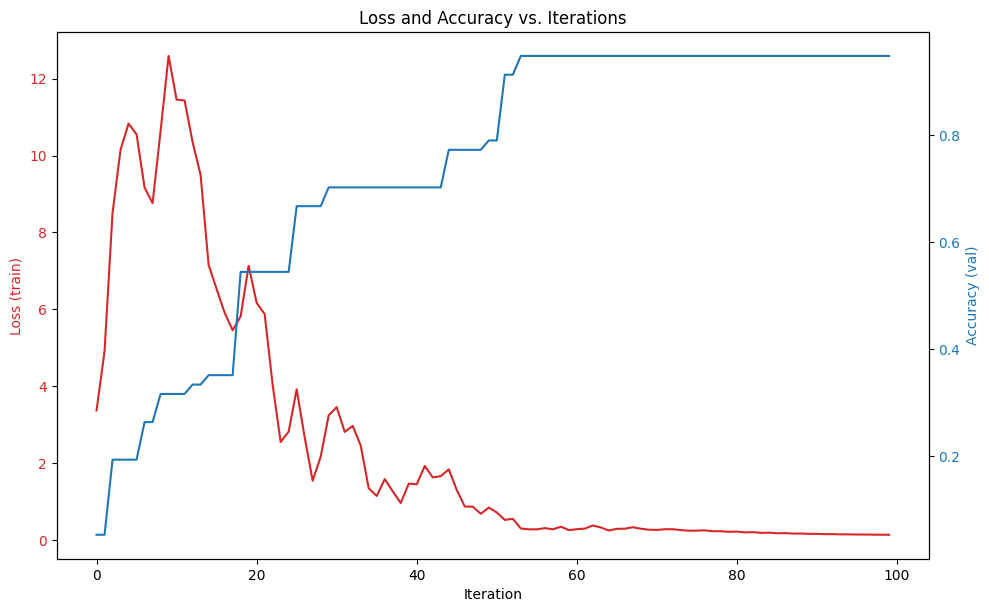

In [13]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:red"
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss (train)", color=color)
ax1.plot(loss_train_history, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("Accuracy (val)", color=color)  # we already handled the x-label with ax1
ax2.plot(acc_val_history, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Loss and Accuracy vs. Iterations")
plt.show()

## Resultados (inferência)

**5. (1 ponto)** Realize as inferências finais no conjunto de teste preenchendo a célula abaixo. Visualize o resultado do teste.

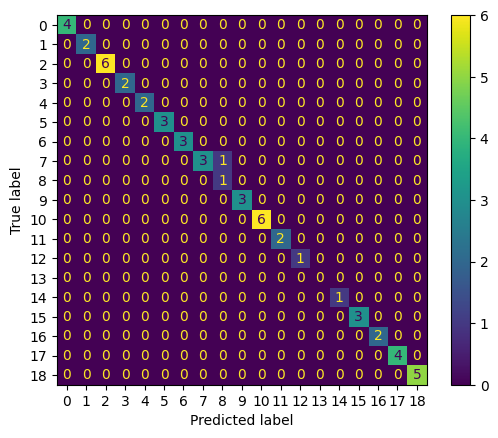


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         4
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         4
   

In [16]:
# TODO: Predict classes on test set ###################
y_pred = predict_class(X_test, best_W)
#######################################################

assert y_pred is not None, "y_pred is not set"

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[class_id for class_id in range(19)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_id for class_id in range(19)])
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred, target_names=[str(class_id) for class_id in range(19)])

print("\nClassification Report:")
print(class_report)